In [86]:
import pyart
import numpy as np
import nexradaws
import tempfile
import xarray as xr
import time
import warnings
from netCDF4 import Dataset
import datetime
import matplotlib.pyplot as plt
import os

warnings.filterwarnings("ignore")

In [87]:
# Central lat/lon of ARM SGP site 
site_latlon = [36.607322, -97.487643]

In [88]:
# Create temp file, connect to NEXRAD AWS, request files by station ID and start/end times (UTC)
templocation = tempfile.mkdtemp()
conn = nexradaws.NexradAwsInterface()

radar_id = 'KVNX'
start = datetime.datetime(2019,8,22,6,0) 
end = datetime.datetime(2019,8,22,12,0)
#start = datetime.datetime(2019,9,21,19,45)
#end = datetime.datetime(2019,9,21,20,30)
#start = datetime.datetime(2021,6,2,14,30)
#end = datetime.datetime(2021,6,2,21,0)
#start = datetime.datetime(2015,12,12,22,0)
#end = datetime.datetime(2015,12,12,23,30)

scans = conn.get_avail_scans_in_range(start, end, radar_id)
print("There are {} scans available between {} and {}\n".format(len(scans), start, end)) 

There are 66 scans available between 2019-08-22 06:00:00 and 2019-08-22 12:00:00



In [89]:
# Get all the scans that don't end in MDM; count them
count_scans = 0
good_scans = []
for i in range(len(scans)):
    this_str = str(scans[i])
    if this_str[-8::] != 'V06_MDM>':
        good_scans.append(scans[i])
        count_scans +=1
    else:
        print('Ignore:',this_str)
        i+=1
print(count_scans)

Ignore: <AwsNexradFile object - 2019/08/22/KVNX/KVNX20190822_065603_V06_MDM>
Ignore: <AwsNexradFile object - 2019/08/22/KVNX/KVNX20190822_075653_V06_MDM>
Ignore: <AwsNexradFile object - 2019/08/22/KVNX/KVNX20190822_085730_V06_MDM>
Ignore: <AwsNexradFile object - 2019/08/22/KVNX/KVNX20190822_095631_V06_MDM>
Ignore: <AwsNexradFile object - 2019/08/22/KVNX/KVNX20190822_105739_V06_MDM>
Ignore: <AwsNexradFile object - 2019/08/22/KVNX/KVNX20190822_115825_V06_MDM>
60


In [90]:
# Download selected volume scans
localfiles = conn.download(good_scans, templocation)

Downloaded KVNX20190822_060839_V06
Downloaded KVNX20190822_061431_V06
Downloaded KVNX20190822_063203_V06
Downloaded KVNX20190822_062610_V06
Downloaded KVNX20190822_063803_V06
Downloaded KVNX20190822_060248_V06
Downloaded KVNX20190822_064400_V06
Downloaded KVNX20190822_065001_V06
Downloaded KVNX20190822_065603_V06
Downloaded KVNX20190822_070818_V06
Downloaded KVNX20190822_071426_V06
Downloaded KVNX20190822_062023_V06
Downloaded KVNX20190822_070211_V06
Downloaded KVNX20190822_073235_V06
Downloaded KVNX20190822_073831_V06
Downloaded KVNX20190822_072640_V06
Downloaded KVNX20190822_074438_V06
Downloaded KVNX20190822_075653_V06
Downloaded KVNX20190822_075046_V06
Downloaded KVNX20190822_072033_V06
Downloaded KVNX20190822_082704_V06
Downloaded KVNX20190822_080301_V06
Downloaded KVNX20190822_081500_V06
Downloaded KVNX20190822_082102_V06
Downloaded KVNX20190822_083305_V06
Downloaded KVNX20190822_083905_V06
Downloaded KVNX20190822_090316_V06
Downloaded KVNX20190822_085730_V06
Downloaded KVNX20190

In [91]:
sweep = np.arange(0, 18, 1)
gate_lat_site = np.nan*np.ma.ones((count_scans,18))
gate_lon_site = np.nan*np.ma.ones((count_scans,18))
gate_hgt_site = np.nan*np.ma.ones((count_scans,18))
Z_site = np.nan*np.ma.ones((count_scans,18))
scan_times = []
tol = 0.25
j = 0 

# Loop through the volume scans
for scan in localfiles.iter_success():
    print('Reading in: '+scan.filename)

    # Read in the volume scans, get the times of the scans
    radar = pyart.io.read(localfiles.success[j].filepath)
    volume_scan_t = scan.scan_time
    scan_times.append(volume_scan_t)

    # Get rid of duplicate sweeps; only interested in the first sweep at a given height
    # Find the median elevation in each sweep to ID and select only the unique sweeps
    vcp = np.asarray([np.median(el_this_sweep) for el_this_sweep in radar.iter_elevation()], dtype=radar.elevation['data'].dtype)
    close_enough = (vcp/tol).astype('int32')
    unq_el, unq_idx = np.unique(close_enough, return_index=True)
    #print(vcp/tol)
    #print(unq_idx)
        
    # Create a new radar object with only the unique sweeps
    myradar = radar.extract_sweeps(unq_idx)
    
    # Loop through all the sweeps in a volume scan
    for k in range(myradar.nsweeps):
        slice_start, slice_end = myradar.get_start_end(k)
        gate_longitude = myradar.gate_longitude['data'][slice_start:slice_end,:]
        gate_latitude = myradar.gate_latitude['data'][slice_start:slice_end,:]
        gate_altitude = myradar.gate_altitude['data'][slice_start:slice_end,:]

        # Find the gate closest to the desired site 
        # Get the lat,lon,alt,reflectivity of the gate closest to the desired site
        dist = np.sqrt(((gate_latitude - site_latlon[0])**2) + ((gate_longitude - site_latlon[1])**2))
        index = np.where(dist == np.min(dist))
        gate_lat_site[j,k] = gate_latitude[index[0][0], index[1][0]]
        gate_lon_site[j,k] = gate_longitude[index[0][0], index[1][0]]
        gate_hgt_site[j,k] = gate_altitude[index[0][0], index[1][0]]
        Z_site[j,k] = myradar.fields['reflectivity']['data'][slice_start+index[0][0], index[1][0]]

    if j < (count_scans-1):
        j += 1
        del radar
    else:
        print('Done')
            
print(Z_site)

Reading in: KVNX20190822_060248_V06
Reading in: KVNX20190822_060839_V06
Reading in: KVNX20190822_061431_V06
Reading in: KVNX20190822_062023_V06
Reading in: KVNX20190822_062610_V06
Reading in: KVNX20190822_063203_V06
Reading in: KVNX20190822_063803_V06
Reading in: KVNX20190822_064400_V06
Reading in: KVNX20190822_065001_V06
Reading in: KVNX20190822_065603_V06
Reading in: KVNX20190822_070211_V06
Reading in: KVNX20190822_070818_V06
Reading in: KVNX20190822_071426_V06
Reading in: KVNX20190822_072033_V06
Reading in: KVNX20190822_072640_V06
Reading in: KVNX20190822_073235_V06
Reading in: KVNX20190822_073831_V06
Reading in: KVNX20190822_074438_V06
Reading in: KVNX20190822_075046_V06
Reading in: KVNX20190822_075653_V06
Reading in: KVNX20190822_080301_V06
Reading in: KVNX20190822_080909_V06
Reading in: KVNX20190822_081500_V06
Reading in: KVNX20190822_082102_V06
Reading in: KVNX20190822_082704_V06
Reading in: KVNX20190822_083305_V06
Reading in: KVNX20190822_083905_V06
Reading in: KVNX20190822_084

In [92]:
# Create an xarray dataset with dimensions time and sweep
ds = xr.Dataset({'Z_site': (['time', 'sweep'], Z_site),
            'gate_lat_site': (['time', 'sweep'], gate_lat_site),
            'gate_lon_site': (['time', 'sweep'], gate_lon_site),
            'gate_hgt_site': (['time', 'sweep'], gate_hgt_site)
            },
            coords={'time': scan_times,'sweep': sweep})
ds

<xarray.Dataset>
Dimensions:        (sweep: 18, time: 60)
Coordinates:
  * time           (time) object 2019-08-22T06:02:48+00:00 ... 2019-08-22T11:...
  * sweep          (sweep) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17
Data variables:
    Z_site         (time, sweep) float64 11.5 9.0 6.5 nan ... nan nan nan nan
    gate_lat_site  (time, sweep) float64 36.61 36.61 36.61 36.61 ... nan nan nan
    gate_lon_site  (time, sweep) float64 -97.49 -97.49 -97.49 ... nan nan nan
    gate_hgt_site  (time, sweep) float64 1.083e+03 1.489e+03 ... nan nan

In [93]:
# Add units
Z_site.attrs = ds.Z_site.attrs
Z_site.attrs["units"] = "dBZ"
gate_hgt_site.attrs = ds.gate_hgt_site.attrs
gate_hgt_site.attrs['units'] = 'Meters'

In [94]:
#radar.info()

Text(0.5, 1.0, 'Reflectivity above ARM SGP Site')

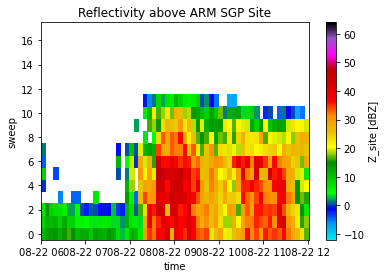

In [95]:
# Quick plot of reflectivity (time vs. sweep)
ds.Z_site.plot(x='time', y='sweep', vmin = -12, vmax = 64, cmap = pyart.graph.cm.NWSRef)
plt.title('Reflectivity above ARM SGP Site')

In [99]:
# Create an array of size time by # height bins to hold scan times & avg ref
x = ds.time
y = np.arange(0.,16000.,800.)
Z_ave = np.nan*np.ones((len(x), len(y)))
xm, ym = np.meshgrid(y, x)

# Calculate avg reflectivity between two height bins for time vs. height plots 
for i in range(len(x)):
    for j in range(19):
        inds = np.argwhere(np.logical_and(ds.gate_hgt_site.values[i, :] >= y[j], 
                                          ds.gate_hgt_site.values[i, :] < y[j+1]))
        Z_ave[i, j] = np.nanmean(ds.Z_site.values[i, inds])

Text(0.5, 1.0, 'Reflectivity above ARM SGP Site: 08/22/19 06:02:48Z - 08/22/19 11:58:25Z\n')

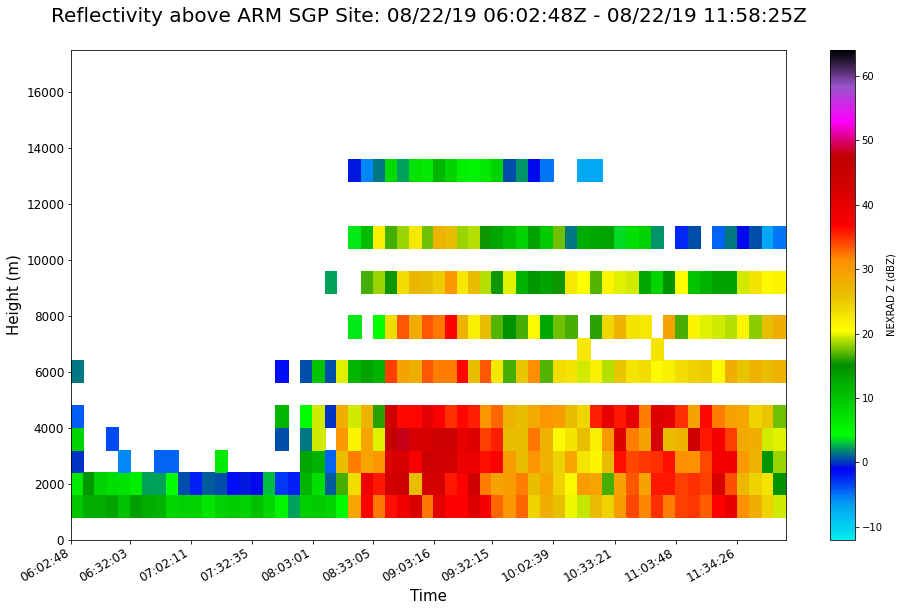

In [100]:
# Make time-height plot of reflectivity over the site
fig = plt.figure(figsize = [16,10])
plt.pcolormesh(ym, xm, Z_ave, vmin = -12, vmax = 64, cmap = pyart.graph.cm.NWSRef)
plt.colorbar(label='NEXRAD Z (dBZ)')
plt.xlabel('Time', size=15)
plt.ylabel('Height (m)', size=15)

times = ds.time.values
datetm = []
tm = []

for x in times:
    date_time = x.strftime('%m/%d/%y %H:%M:%S')
    t = x.strftime('%H:%M:%S')
    datetm.append(date_time)
    tm.append(t)
plt.xticks(ticks=times, labels=tm, size=12)
plt.yticks(size=12)
plt.ylim(0,17500)
ax = plt.gca()
n=5
ax.set_xticks(ax.get_xticks()[::n])
fig.autofmt_xdate()

plt.title('Reflectivity above ARM SGP Site: {}Z - {}Z\n'.format(datetm[0], datetm[-1]), size=20)

Text(0.5, 1.0, 'Reflectivity above ARM SGP Site: 08/22/19 06:02:48Z - 08/22/19 11:58:25Z\n')

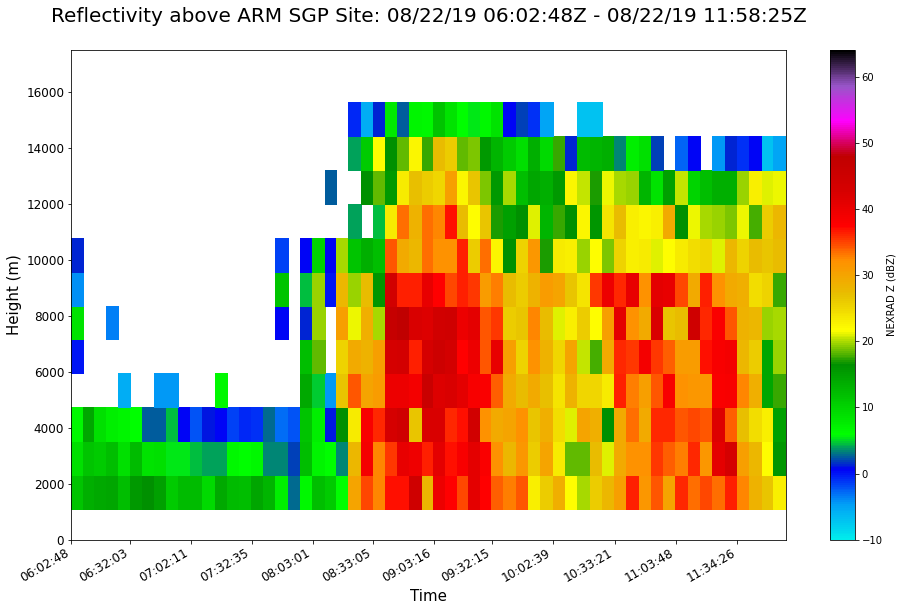

In [101]:
# Alternative way to plot -> using evenly spaced values between min/max gate height for y-axis
# Doesn't do a great job with the heights (they're too high)
height_axis = np.linspace(ds.gate_hgt_site.min(), ds.gate_hgt_site.max(), len(ds.sweep))

x = times
y = height_axis
xm, ym = np.meshgrid(x, y)

fig = plt.figure(figsize = [16,10])
plt.pcolormesh(x, y, ds.Z_site.T,
               vmin = -10, vmax = 64, cmap = pyart.graph.cm.NWSRef)

plt.colorbar(label='NEXRAD Z (dBZ)')
plt.xlabel('Time', size=15)
plt.ylabel('Height (m)', size=15)

times = ds.time.values
datetm = []
tm = []

for x in times:
    date_time = x.strftime('%m/%d/%y %H:%M:%S')
    t = x.strftime('%H:%M:%S')
    datetm.append(date_time)
    tm.append(t)
plt.xticks(ticks=times, labels=tm, size=12)
plt.yticks(size=12)
plt.ylim(0,17500)
ax = plt.gca()
n=5
ax.set_xticks(ax.get_xticks()[::n])
fig.autofmt_xdate()

plt.title('Reflectivity above ARM SGP Site: {}Z - {}Z\n'.format(datetm[0], datetm[-1]), size=20)